In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib  # Para guardar y cargar modelos

In [2]:
# Cargar los datos limpios
data = pd.read_csv('../files/Datos_empleados_historico_limpio.csv')
data.describe

<bound method NDFrame.describe of         id  edad abandono             viajes            departamento  \
0        1    41      Yes      Travel_Rarely                   Sales   
1        2    49       No  Travel_Frequently  Research & Development   
2        4    37      Yes      Travel_Rarely  Research & Development   
3        5    33       No  Travel_Frequently  Research & Development   
4        7    27       No      Travel_Rarely  Research & Development   
...    ...   ...      ...                ...                     ...   
1265  2061    36       No  Travel_Frequently  Research & Development   
1266  2062    39       No      Travel_Rarely  Research & Development   
1267  2064    27       No      Travel_Rarely               Financial   
1268  2065    49       No  Travel_Frequently                   Sales   
1269  2068    34       No      Travel_Rarely  Research & Development   

      distancia_casa      educacion                    carrera  \
0                  1  Universitaria

In [3]:
# Transformación de la variable 'abandono' de Yes/No a 1/0
data['abandono'] = data['abandono'].map({'Yes': 1, 'No': 0})
data = data.drop(columns=['id'])


In [4]:
# Transformación de variables categóricas en variables dummies
categorical_vars = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_vars, drop_first=True)

In [5]:
data.head

<bound method NDFrame.head of       edad  abandono  distancia_casa  nivel_laboral  salario_mes  \
0       41         1               1              2       5993.0   
1       49         0               8              2       5130.0   
2       37         1               2              1       2090.0   
3       33         0               3              1       2909.0   
4       27         0               2              1       3468.0   
...    ...       ...             ...            ...          ...   
1265    36         0              23              2       2571.0   
1266    39         0               6              3       9991.0   
1267    27         0               4              2       6142.0   
1268    49         0               2              2       5390.0   
1269    34         0               8              2       4404.0   

      num_empresas_anteriores  incremento_salario_porc  nivel_acciones  \
0                           8                       11               0   
1    

In [6]:
# División de los datos en entrenamiento y prueba
X = data.drop('abandono', axis=1)
y = data['abandono']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar si hay valores NaN en y_train
if np.any(np.isnan(y_train)):
    # Eliminar filas con NaN en y_train
    mask = ~np.isnan(y_train)
    X_train = X_train[mask]
    y_train = y_train[mask]

In [7]:
if X_train.shape[0] == 0:
    print("X_train está vacío después de la limpieza de datos.")

In [8]:
# Escalado de características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Definición de modelos
models = {
    'Regresión Logística': LogisticRegression(max_iter=1000, random_state=42),
    'Árbol de Decisión': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Red Neuronal': MLPClassifier(max_iter=1000, random_state=42)
}

In [10]:
# Entrenamiento y evaluación de modelos
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva (abandono)

    auc = roc_auc_score(y_test, y_pred_proba)

    y_pred_binary = (y_pred_proba >= 0.6).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    
    results[name] = {'AUC': auc, 'Accuracy': accuracy, 'Recall': recall, 'F1-score': f1}
    
    print(f"\n{name} - Reporte de Clasificación")
    print(classification_report(y_test, y_pred_binary))


Regresión Logística - Reporte de Clasificación
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       221
           1       0.71      0.30      0.43        33

    accuracy                           0.89       254
   macro avg       0.81      0.64      0.68       254
weighted avg       0.88      0.89      0.87       254


Árbol de Decisión - Reporte de Clasificación
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       221
           1       0.42      0.45      0.43        33

    accuracy                           0.85       254
   macro avg       0.67      0.68      0.67       254
weighted avg       0.85      0.85      0.85       254


Random Forest - Reporte de Clasificación
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       221
           1       0.86      0.18      0.30        33

    accuracy                           0.89   

In [11]:
# Resultados comparativos
results_df = pd.DataFrame(results).T

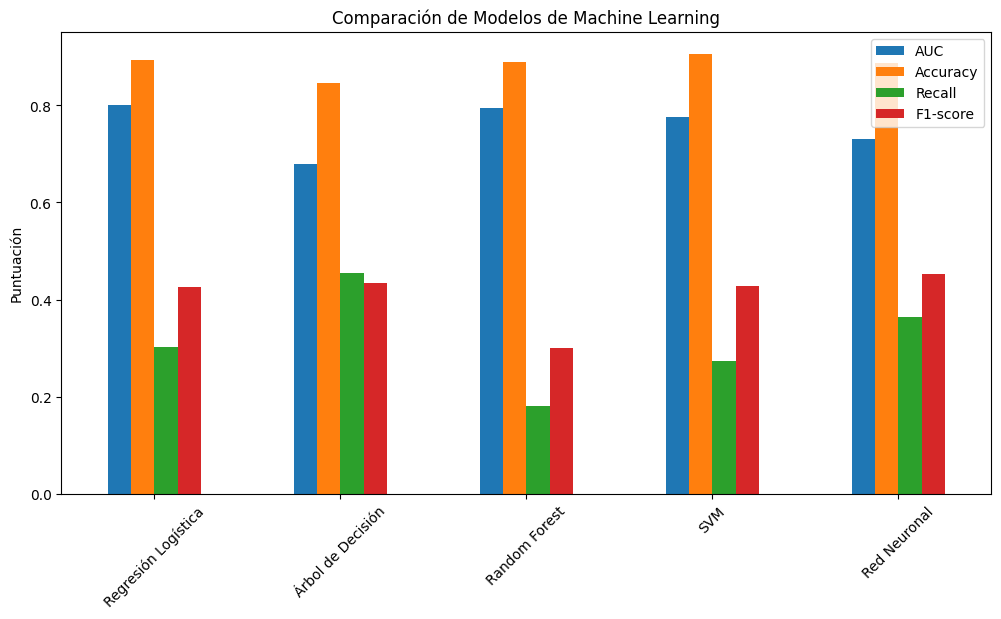

In [12]:
# Visualización de resultados
results_df[['AUC', 'Accuracy', 'Recall', 'F1-score']].plot(kind='bar', figsize=(12, 6))
plt.title('Comparación de Modelos de Machine Learning')
plt.ylabel('Puntuación')
plt.xticks(rotation=45)
plt.show()

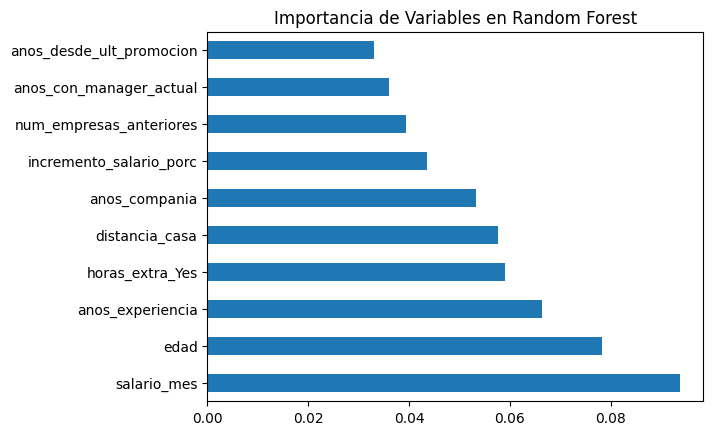

In [13]:
# Identificación de variables más influyentes (para Random Forest)
feature_importances = pd.Series(models['Random Forest'].feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Importancia de Variables en Random Forest')
plt.show()

In [14]:
# Guardar el modelo Random Forest entrenado
best_model = models['Random Forest']
joblib.dump(best_model, 'modelo_random_forest.pkl')

['modelo_random_forest.pkl']

In [15]:
# Aplicar el modelo guardado a la base de datos de actuales para predecir probabilidades
def predecir_abandono(nueva_base_path):
    nueva_base = pd.read_excel(nueva_base_path)
    ids = nueva_base['id']
    categorical_vars_new = nueva_base.select_dtypes(include=['object']).columns
    nueva_base = pd.get_dummies(nueva_base, columns=categorical_vars_new, drop_first=True)
    nueva_base = nueva_base.reindex(columns=X.columns, fill_value=0)
    nueva_base_scaled = scaler.transform(nueva_base)
    modelo_cargado = joblib.load('modelo_random_forest.pkl')
    predicciones_proba = modelo_cargado.predict_proba(nueva_base_scaled)[:, 1]
    resultados = pd.DataFrame({'id': ids, 'probabilidad_abandono': predicciones_proba})
    top_10_abandono = resultados.sort_values(by='probabilidad_abandono', ascending=False).head(10)
    print("Top 10 empleados con mayor probabilidad de abandonar la empresa:")
    print(top_10_abandono[['id', 'probabilidad_abandono']])


In [16]:
ruta = "../files/Data_empleados_actuales_.xlsx"
predecir_abandono(ruta)

Top 10 empleados con mayor probabilidad de abandonar la empresa:
       id  probabilidad_abandono
128  2021                   0.78
23   1783                   0.75
127   749                   0.70
162  1108                   0.66
150  1055                   0.63
46    201                   0.62
146  1495                   0.57
94   1844                   0.57
20     22                   0.55
177  1012                   0.54
